In [100]:
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re


from rmexp import schema


In [176]:
exps = ['face3pool3pingpong3lego3',
        'face4pool4pingpong4lego4', 'face5pool4pingpong4lego4', 'face5pool4pingpong4lego5',
        'face5pool5pingpong4lego5', 'face5pool5pingpong5lego5', 'face5pool5pingpong5lego6',
        'face5pool6pingpong5lego6',
        'face5pool6pingpong6lego6', 'face5pool6pingpong6lego7', 'face5pool7pingpong6lego7',
        'face5pool7pingpong7lego7',
        'face8pool8pingpong8lego8']
exps_clients = map(lambda exp: sum(map(int, re.findall('\d+', exp))) , exps)
print(exps_clients)

schemes = ['baseline', 'cpushares', ]
apps = ['face', 'lego', 'pingpong', 'pool']

assert len(exps) == len(set(exps)), "redundant!"

def pretty_app(app):
    dct = {
        'face': 'Face',
        'lego': 'Lego',
        'pingpong': 'Pong Pong',
        'pool': 'Pool',
    }
    return dct[app]

def pretty_scheme(scheme):
    dct = {
        'baseline': 'Gabriel',
        'cpushares': 'Our Allocation',
        'maxmin': 'Our Max-Min',
    }
    return dct[scheme]

app_bounds = {
    'lego': (600, 2700),
    'pingpong': (150, 230),
    'pool': (95, 105),
    'face': (370, 1000),
}

[12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32]


## Max-Sum Utility

In [177]:
# compare total utility of different methods
total_utils = pd.DataFrame()

for scheme in schemes:
    for exp in exps:
        df = pd.read_sql(
            "select sum(utility)/count(distinct name) as utility from ExpLatency where name like %(name)s",
            schema.engine,
            params={'name': exp+'-'+scheme+'%'}
        )
        total_utils = total_utils.append({
            'exp': exp,
            'scheme': scheme,
            'total_utility': df['utility'].iat[0]
        }, ignore_index=True)
        
print(total_utils)

                         exp     scheme  total_utility
0   face3pool3pingpong3lego3   baseline   10039.578220
1   face4pool4pingpong4lego4   baseline    9495.794107
2   face5pool4pingpong4lego4   baseline    9674.512616
3   face5pool4pingpong4lego5   baseline    8648.864912
4   face5pool5pingpong4lego5   baseline    8565.046622
5   face5pool5pingpong5lego5   baseline    8950.159028
6   face5pool5pingpong5lego6   baseline    9078.064552
7   face5pool6pingpong5lego6   baseline    8679.324143
8   face5pool6pingpong6lego6   baseline    8737.138545
9   face5pool6pingpong6lego7   baseline    6392.107654
10  face5pool7pingpong6lego7   baseline    6480.628068
11  face5pool7pingpong7lego7   baseline    5845.263599
12  face8pool8pingpong8lego8   baseline    5374.858834
13  face3pool3pingpong3lego3  cpushares    9298.968603
14  face4pool4pingpong4lego4  cpushares   10367.267709
15  face5pool4pingpong4lego4  cpushares   11554.350198
16  face5pool4pingpong4lego5  cpushares   11554.835350
17  face5p

<IPython.core.display.Javascript object>


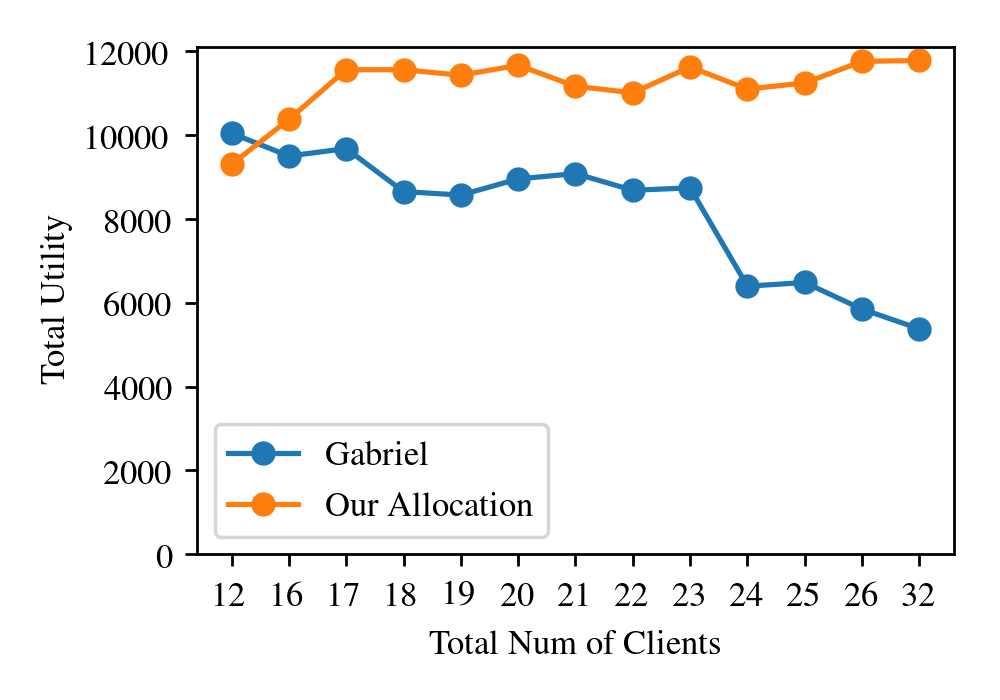

In [187]:
%matplotlib notebook

plt.figure(figsize=(4,2.8))
for scheme in schemes:
    plt.plot('exp', 'total_utility', 'o-', data=total_utils[total_utils['scheme'] == scheme], label=pretty_scheme(scheme))
plt.ylim([0, None])
plt.xticks(exps, exps_clients)
plt.xlabel('Total Num of Clients')
plt.ylabel('Total Utility')
plt.legend()
plt.tight_layout()
plt.savefig('fig-alloc-max-util.pdf')


<IPython.core.display.Javascript object>


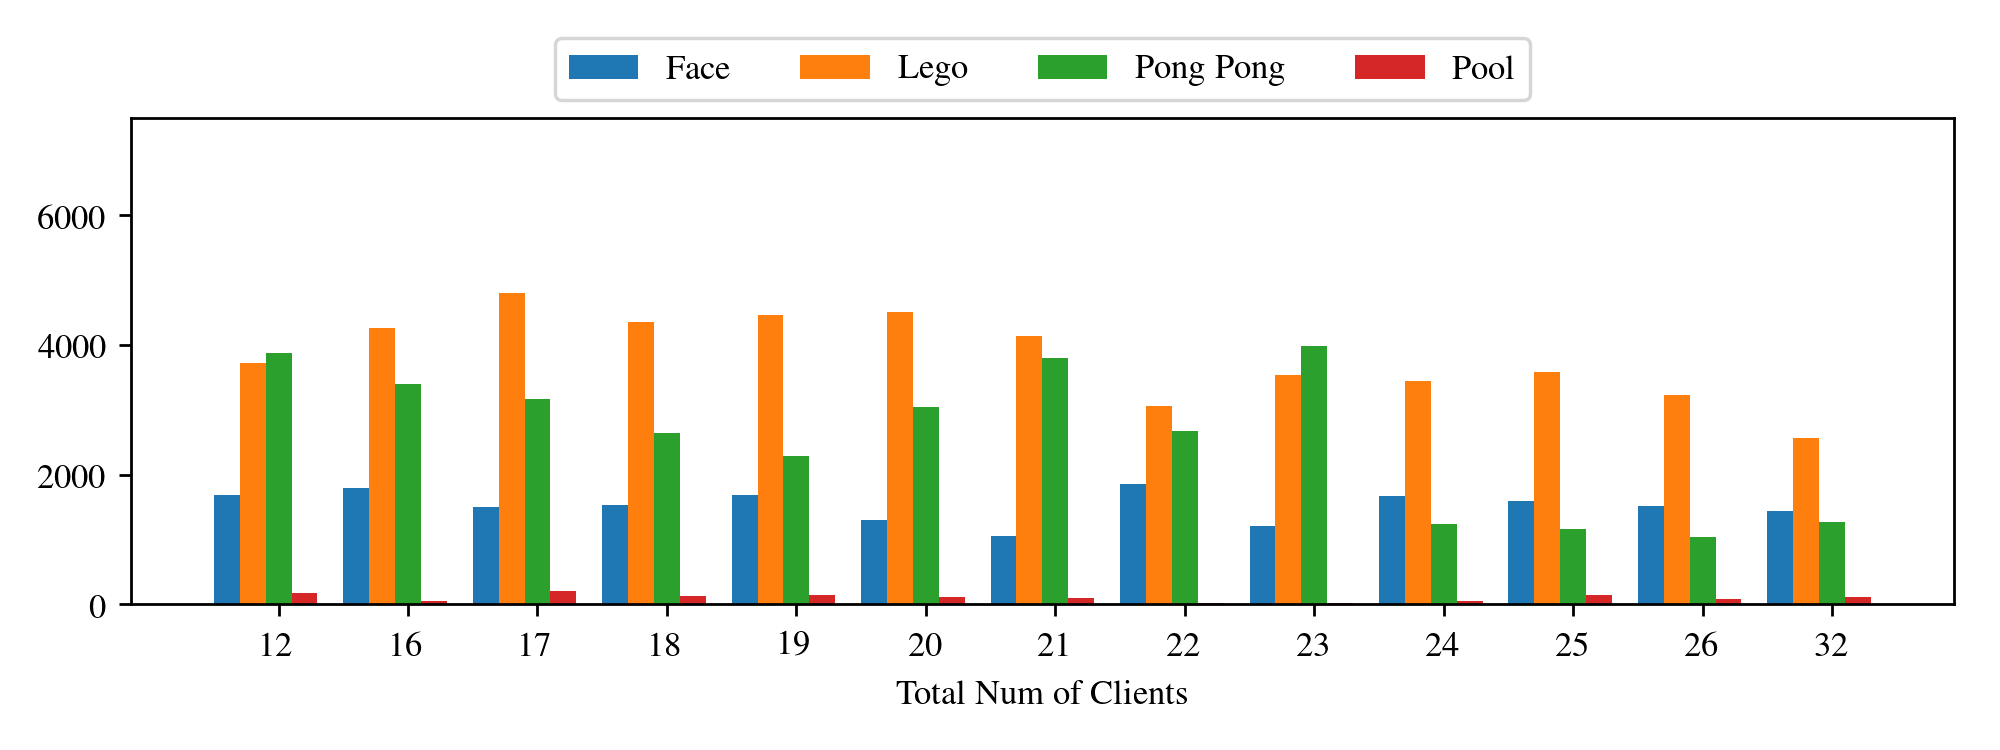

<IPython.core.display.Javascript object>


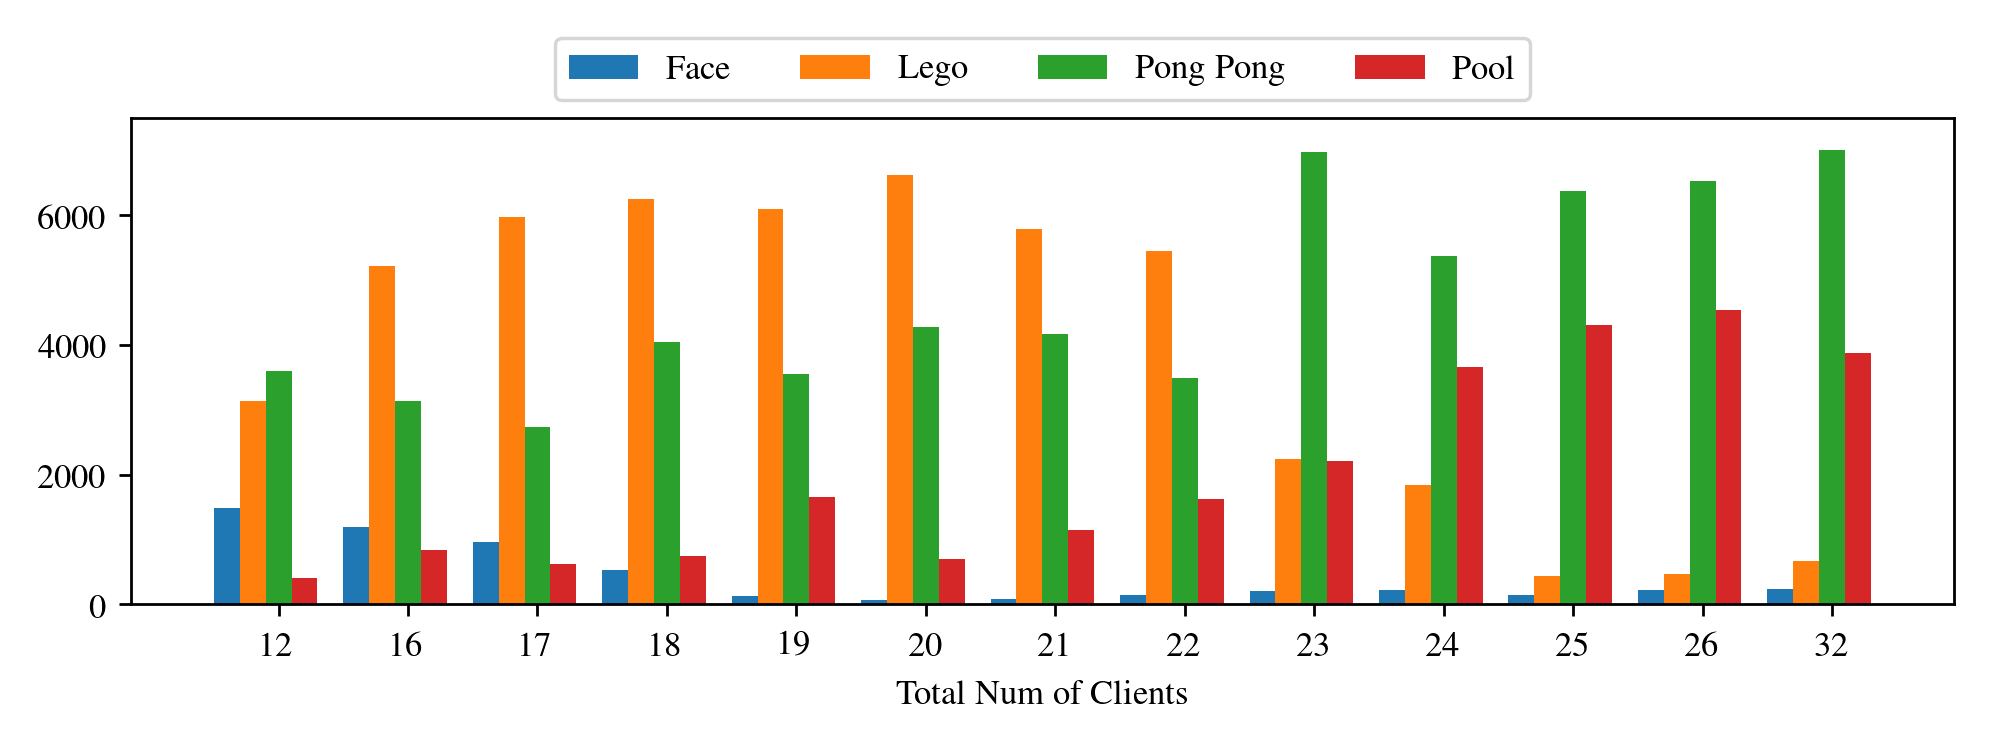

In [110]:
# plot breakdowns of individual apps

for scheme in schemes:
    app_utils = pd.DataFrame()
    
    for exp in exps:
        df = pd.read_sql(
            "select app, sum(utility) as utility from ExpLatency where name=%(name)s group by app",
            schema.engine,
            params={'name': exp+'-'+scheme}
        )
        df['exp'] = exp
        
        app_utils = app_utils.append(df, ignore_index=True)
        
#     print(app_utils)
    
    fig, ax = plt.subplots()
    ind = np.arange(len(exps))
    width = .2
    
    for i, app in enumerate(apps):
        ax.bar(ind + width*i, app_utils[app_utils['app']==app]['utility'], width, label=pretty_app(app))
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(exps_clients)
    ax.set_xlabel('Total Num of Clients')
    ax.set_ylim([0, 7500])
    fig.set_size_inches((8,3))
    ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)
    fig.tight_layout()
    fig.savefig('fig-alloc-{}.pdf'.format(scheme), bbox_inches='tight')
            


         app                       exp  latency
0       face  face3pool3pingpong3lego3    577.0
1       lego  face3pool3pingpong3lego3    144.0
2   pingpong  face3pool3pingpong3lego3    219.0
3       pool  face3pool3pingpong3lego3    571.1
4       face  face4pool4pingpong4lego4    645.0
5       lego  face4pool4pingpong4lego4    212.0
6   pingpong  face4pool4pingpong4lego4    317.0
7       pool  face4pool4pingpong4lego4   1065.2
8       face  face5pool4pingpong4lego4    817.0
9       lego  face5pool4pingpong4lego4    184.0
10  pingpong  face5pool4pingpong4lego4    331.0
11      pool  face5pool4pingpong4lego4    827.0
12      face  face5pool4pingpong4lego5    836.6
13      lego  face5pool4pingpong4lego5    254.0
14  pingpong  face5pool4pingpong4lego5    343.0
15      pool  face5pool4pingpong4lego5    855.0
16      face  face5pool5pingpong4lego5    770.0
17      lego  face5pool5pingpong4lego5    250.0
18  pingpong  face5pool5pingpong4lego5    378.0
19      pool  face5pool5pingpong4lego5  

<IPython.core.display.Javascript object>


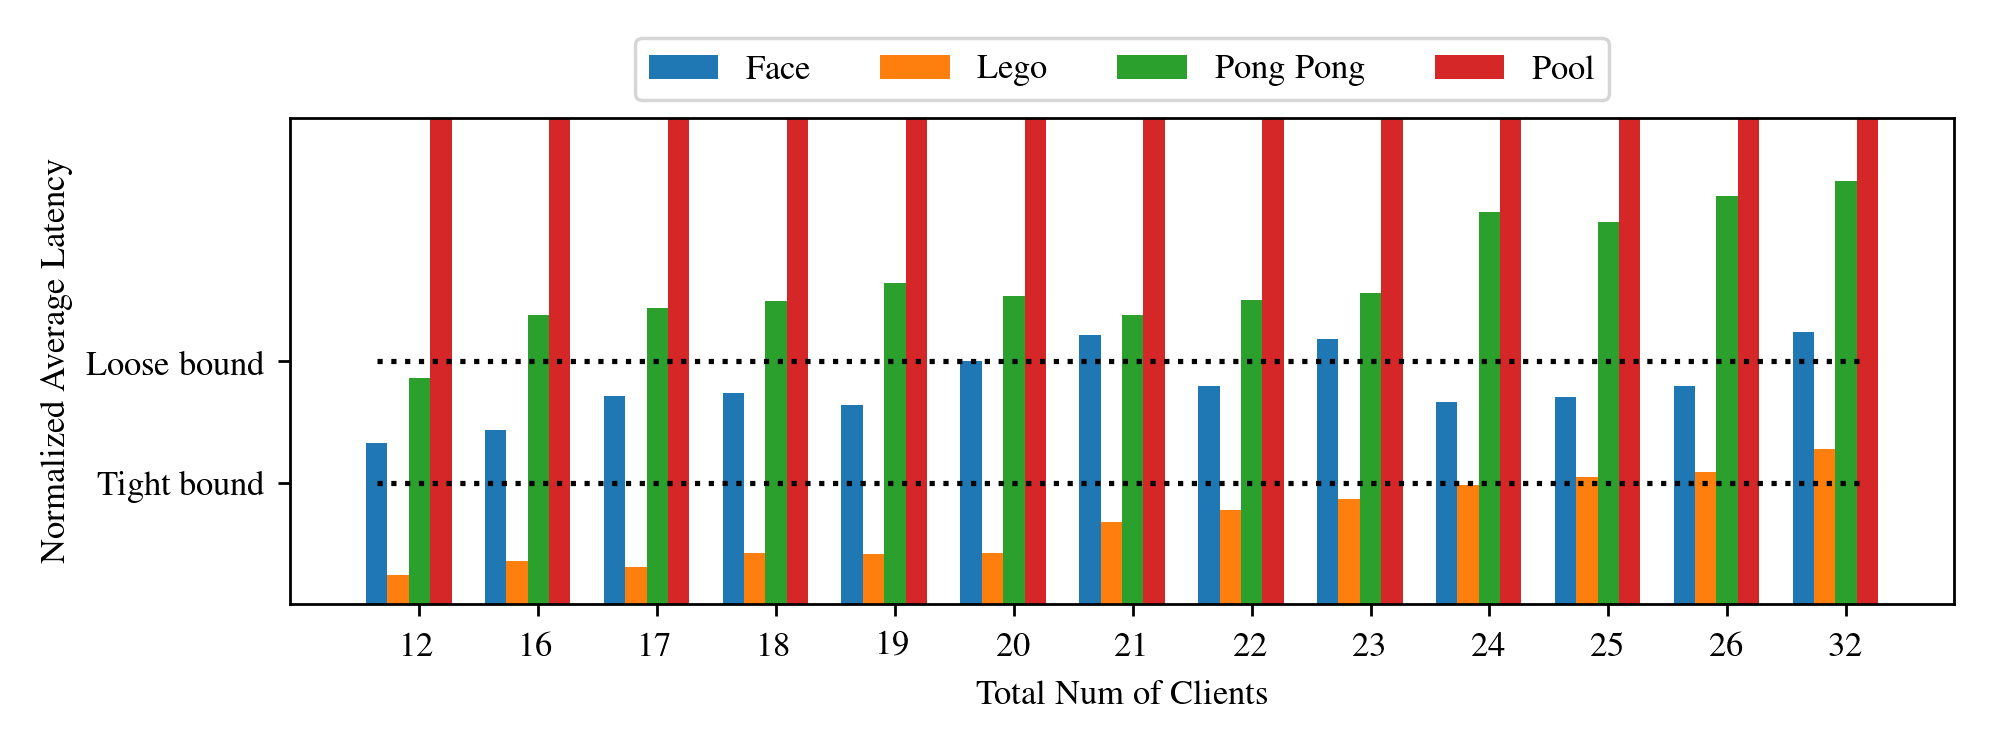

         app                       exp  latency
0       face  face3pool3pingpong3lego3    787.0
1       lego  face3pool3pingpong3lego3    934.0
2   pingpong  face3pool3pingpong3lego3    188.0
3       pool  face3pool3pingpong3lego3    214.8
4       face  face4pool4pingpong4lego4    853.7
5       lego  face4pool4pingpong4lego4    476.0
6   pingpong  face4pool4pingpong4lego4    168.0
7       pool  face4pool4pingpong4lego4    172.0
8       face  face5pool4pingpong4lego4    566.7
9       lego  face5pool4pingpong4lego4    483.0
10  pingpong  face5pool4pingpong4lego4    117.0
11      pool  face5pool4pingpong4lego4    158.0
12      face  face5pool4pingpong4lego5    712.0
13      lego  face5pool4pingpong4lego5    390.0
14  pingpong  face5pool4pingpong4lego5    122.0
15      pool  face5pool4pingpong4lego5    206.0
16      face  face5pool5pingpong4lego5   1869.0
17      lego  face5pool5pingpong4lego5    558.0
18  pingpong  face5pool5pingpong4lego5    159.0
19      pool  face5pool5pingpong4lego5  

<IPython.core.display.Javascript object>


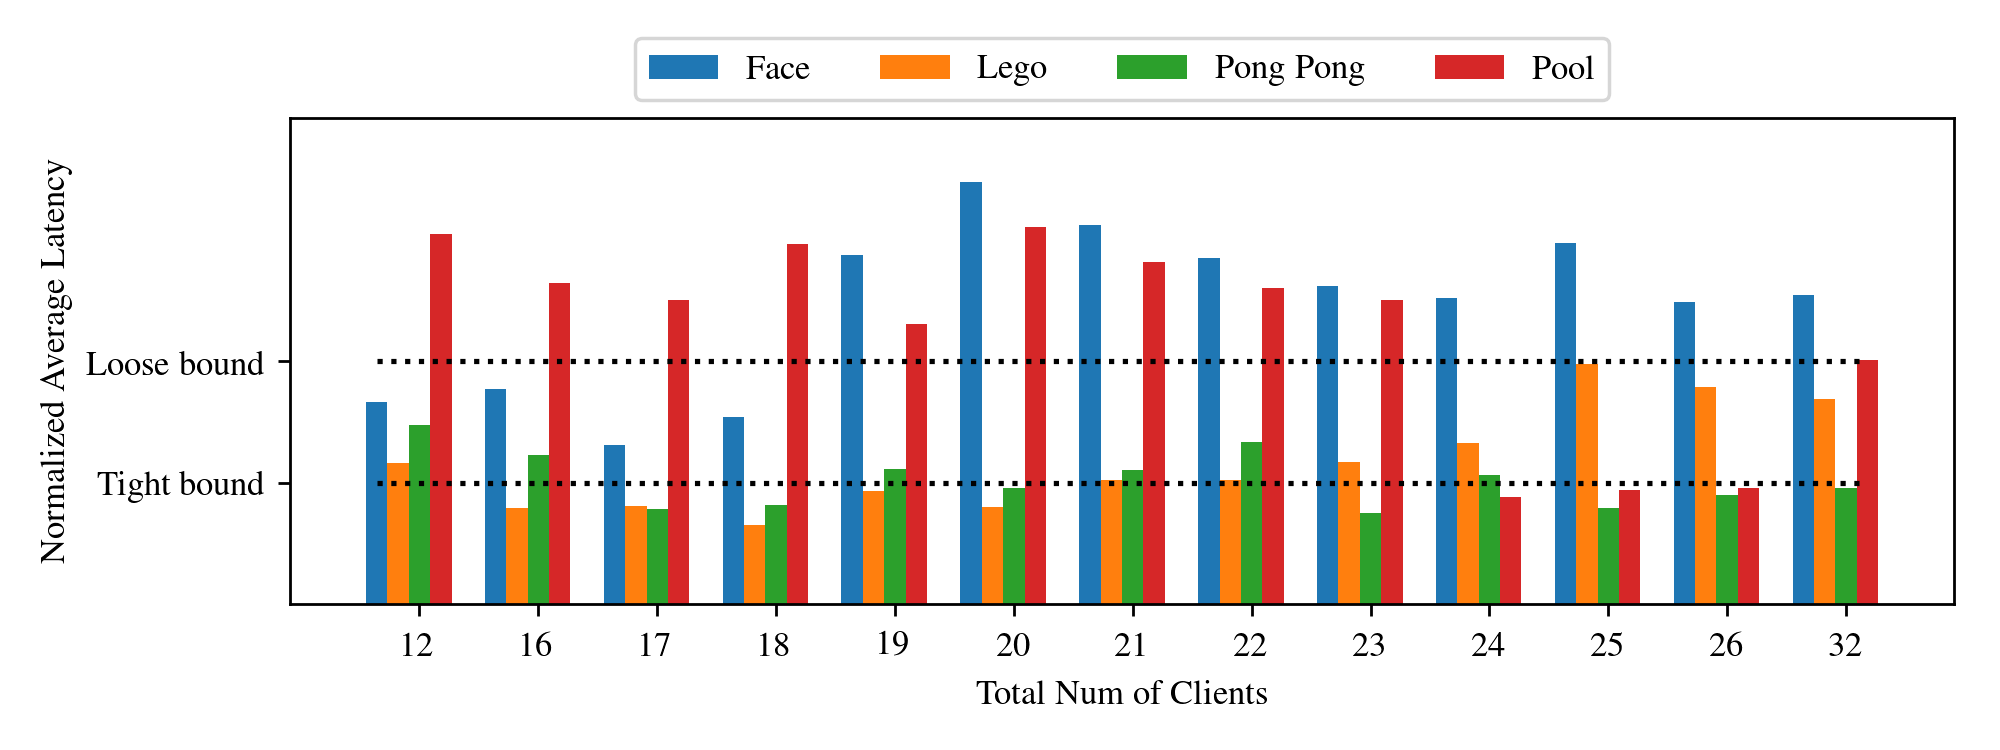

In [184]:
# plot 90%-tile/avg latencies of individual apps

for scheme in schemes:
    app_latency = pd.DataFrame()
    
    for exp in exps:
        for app in apps:
            df = pd.read_sql(
                "select name, app, reply as latency from ExpLatency where name like %(name)s and app=%(app)s",
                schema.engine,
                params={'name': exp+'-'+scheme+'%', 'app': app}
            )
            latency = np.percentile(df['latency'].values, 90)  # 90%-tile

            app_latency = app_latency.append({
                'app': app,
                'exp': exp,
                'latency': latency
                }, ignore_index=True)
        
    print(app_latency)
    
    fig, ax = plt.subplots()
    ind = np.arange(len(exps))
    width = .18
    
    for i, app in enumerate(apps):
        x = ind + width*i
        y = app_latency[app_latency['app']==app]['latency'].values
        
        lb, ub = app_bounds[app]

        y1 = np.ones_like(y)
        y1[y < lb] = y[y < lb] / lb
        y1[np.logical_and(lb <= y, y <= ub)] = 1. + (y[np.logical_and(lb <= y, y <= ub)] - lb) / (ub - lb)
        y1[y > ub] = 1. + y[y > ub] / ub

        ax.bar(x, y1, width, label=pretty_app(app))
    
    ax.hlines(1., 0, len(ind)-.5, colors='k', linestyles='dotted')
    ax.hlines(2., 0, len(ind)-.5, colors='k', linestyles='dotted')
    
    ax.set_yticks([1., 2.])
    ax.set_yticklabels(['Tight bound', 'Loose bound'])
    ax.set_xticks(ind + width * len(apps) / 2 )
    ax.set_xticklabels(exps_clients)
    ax.set_xlabel('Total Num of Clients')
    ax.set_ylabel('Normalized Average Latency')
    ax.set_ylim([0, 4.])
    fig.set_size_inches((8,3))
    ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)
    fig.tight_layout()
    fig.savefig('fig-alloc-latency-{}.pdf'.format(scheme), bbox_inches='tight')
            
